In [108]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

In [109]:
# Load and process the Brent oil price data with feature engineering
def load_and_process_data(file_path):
    """
    Load data, process date and price columns, and add engineered features.
    """
    # Load data
    df = pd.read_csv(file_path, parse_dates=['Date'], dayfirst=True)
    df = df.sort_values(by='Date')
    
    # Ensure there are no missing values
    df = df.dropna(subset=['Price'])
    df.set_index('Date', inplace=True)
    
    # Feature Engineering
    df['Returns'] = df['Price'].pct_change()  # Daily returns
    df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))  # Log returns
    df['Volatility'] = df['Returns'].rolling(window=21).std()  # 21-day rolling volatility
    df['Momentum'] = df['Price'].diff(5)  # 5-day momentum
    
    # Drop any NaN values that result from rolling calculations
    df.dropna(inplace=True)
    
    return df

file_path = 'C:/Users/Administrator/Documents/kifiya/Week_10/data/BrentOilPrices.csv'
df = load_and_process_data(file_path)
display(df.head())

,Price,Returns,Log_Returns,Volatility,Momentum
Date,,,,,
1987-06-19,19.05,0.000000,0.000000,0.004308,0.37
1987-06-22,19.10,0.002625,0.002621,0.003544,0.32
1987-06-23,18.90,-0.010471,-0.010526,0.004313,0.00
1987-06-24,18.75,-0.007937,-0.007968,0.004698,-0.28
1987-06-25,18.70,-0.002667,-0.002670,0.004736,-0.35


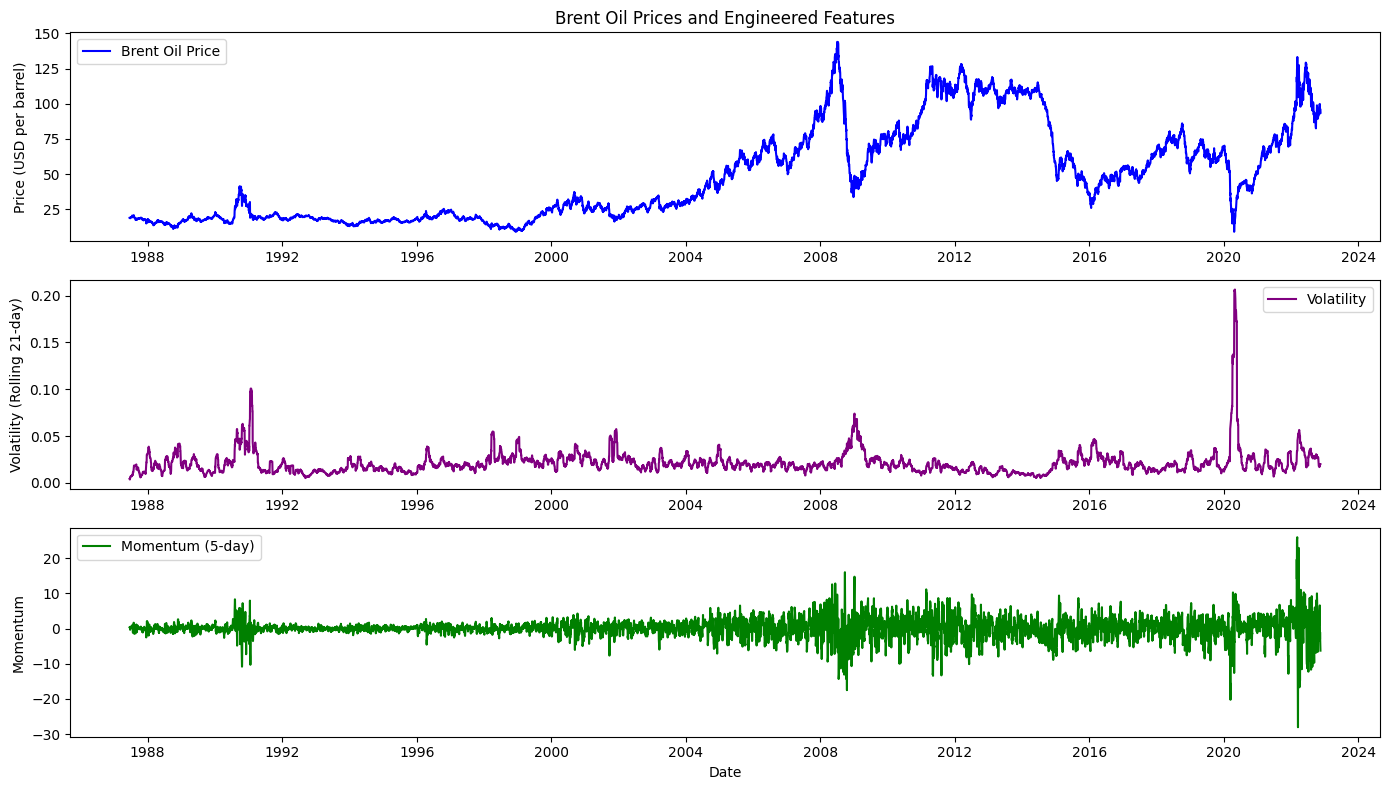

In [110]:
# Exploratory Data Analysis (EDA) - Visualization
def plot_time_series(df):
    """
    Plot the time series of Brent oil prices and engineered features.
    """
    plt.figure(figsize=(14, 8))
    
    # Plot Price
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['Price'], color='blue', label='Brent Oil Price')
    plt.title("Brent Oil Prices and Engineered Features")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()

    # Plot Volatility
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['Volatility'], color='purple', label='Volatility')
    plt.ylabel("Volatility (Rolling 21-day)")
    plt.legend()
    
    # Plot Momentum
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['Momentum'], color='green', label='Momentum (5-day)')
    plt.xlabel("Date")
    plt.ylabel("Momentum")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
 
plot_time_series(df)

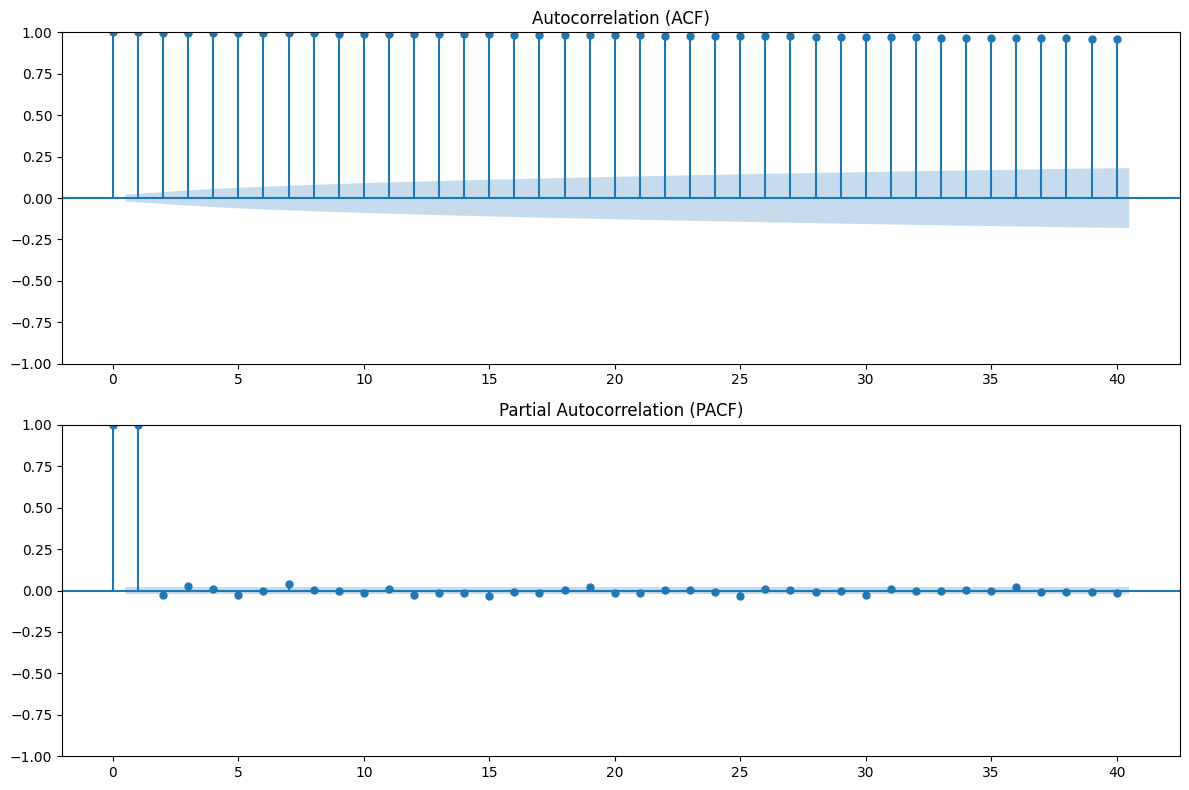

In [111]:
 # Step 1: EDA and Initial Analysis
def plot_acf_pacf(df, column='Price'):
    """
    Plot ACF and PACF for time series analysis.
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(df[column], ax=ax[0])
    plot_pacf(df[column], ax=ax[1])
    ax[0].set_title("Autocorrelation (ACF)")
    ax[1].set_title("Partial Autocorrelation (PACF)")
    plt.tight_layout()
    plt.show()


plot_acf_pacf(df)

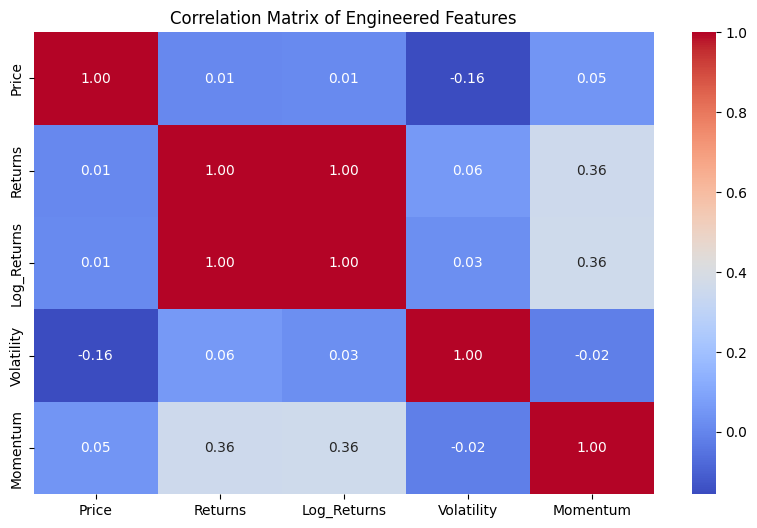

In [112]:
def correlation_analysis(df):
    """
    Plot a heatmap to show correlation among features.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Engineered Features")
    plt.show()

correlation_analysis(df)

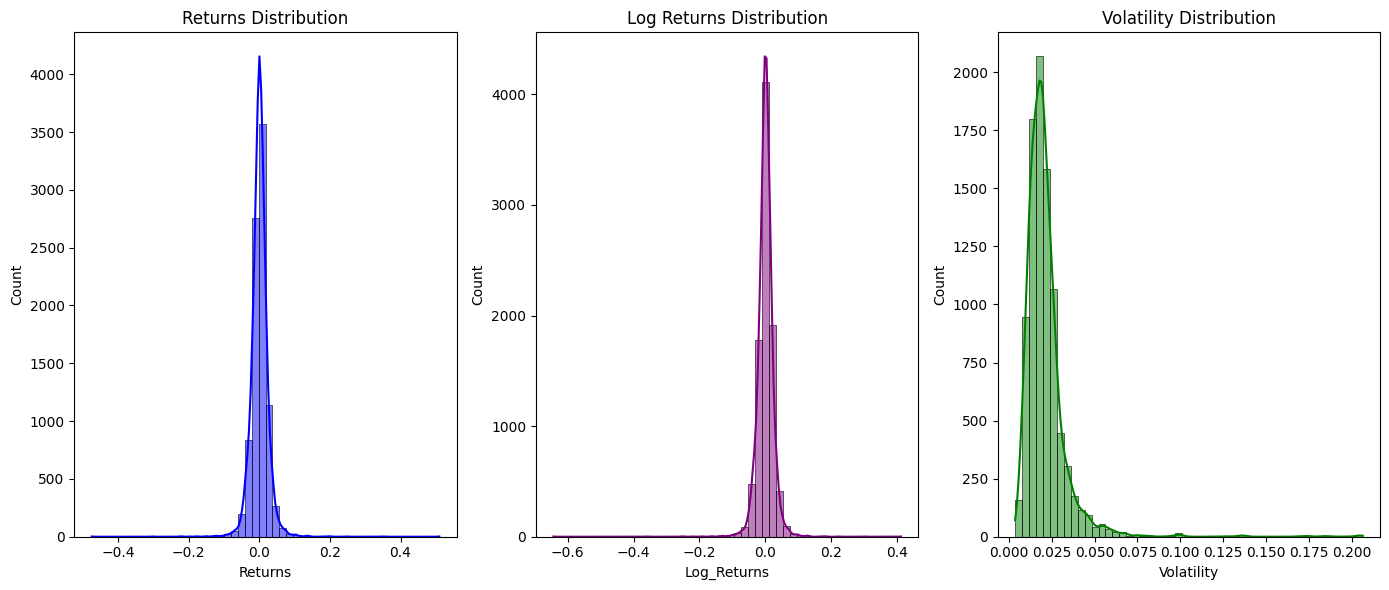

In [113]:

# Distribution Analysis
def distribution_analysis(df):
    """
    Visualize distributions of key features: Returns, Log Returns, and Volatility.
    """
    plt.figure(figsize=(14, 6))
    
    # Returns Distribution
    plt.subplot(1, 3, 1)
    sns.histplot(df['Returns'], bins=50, color='blue', kde=True)
    plt.title("Returns Distribution")

    # Log Returns Distribution
    plt.subplot(1, 3, 2)
    sns.histplot(df['Log_Returns'], bins=50, color='purple', kde=True)
    plt.title("Log Returns Distribution")
    
    # Volatility Distribution
    plt.subplot(1, 3, 3)
    sns.histplot(df['Volatility'], bins=50, color='green', kde=True)
    plt.title("Volatility Distribution")
    
    plt.tight_layout()
    plt.show()

distribution_analysis(df)

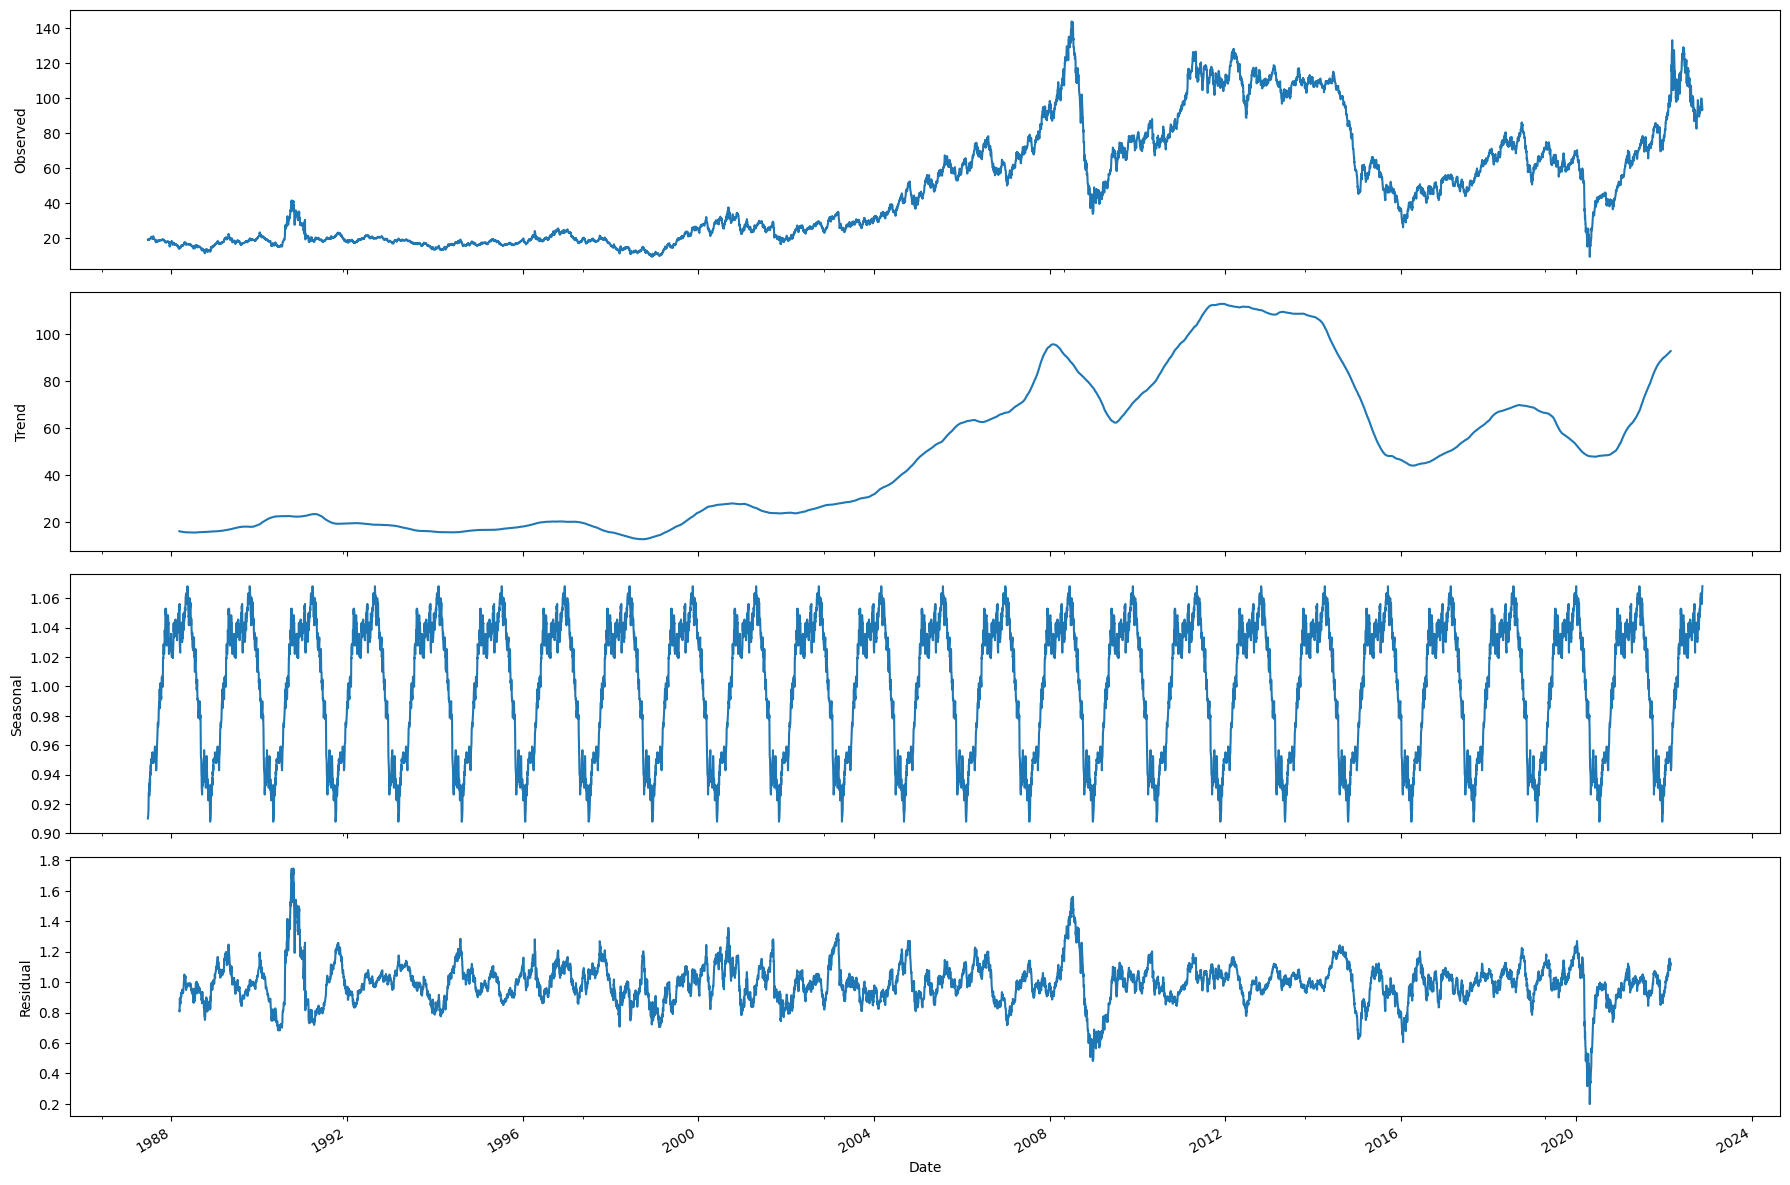

In [114]:
# Seasonality Analysis
def seasonality_analysis(df):
    """
    Perform seasonal decomposition to analyze trends, seasonality, and residuals with a wider layout.
    """
    decomposition = seasonal_decompose(df['Price'], model='multiplicative', period=365)

    # Set up a wider figure
    fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)
    
    # Plot each component with wider axes
    decomposition.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    
    decomposition.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    
    decomposition.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    
    decomposition.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')
    
    plt.tight_layout()
    plt.show()

seasonality_analysis(df)

In [115]:
# Risk Metrics Calculation
def calculate_risk_metrics(df, confidence_level=0.05):
    """
    Calculate Value at Risk (VaR) and Expected Shortfall (ES) for returns.
    """
    var = np.percentile(df['Returns'].dropna(), 100 * confidence_level)
    es = df['Returns'][df['Returns'] <= var].mean()
    
    print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {var:.4f}")
    print(f"Expected Shortfall (ES) at {confidence_level*100}% confidence level: {es:.4f}")


calculate_risk_metrics(df)

Value at Risk (VaR) at 5.0% confidence level: -0.0358
Expected Shortfall (ES) at 5.0% confidence level: -0.0546


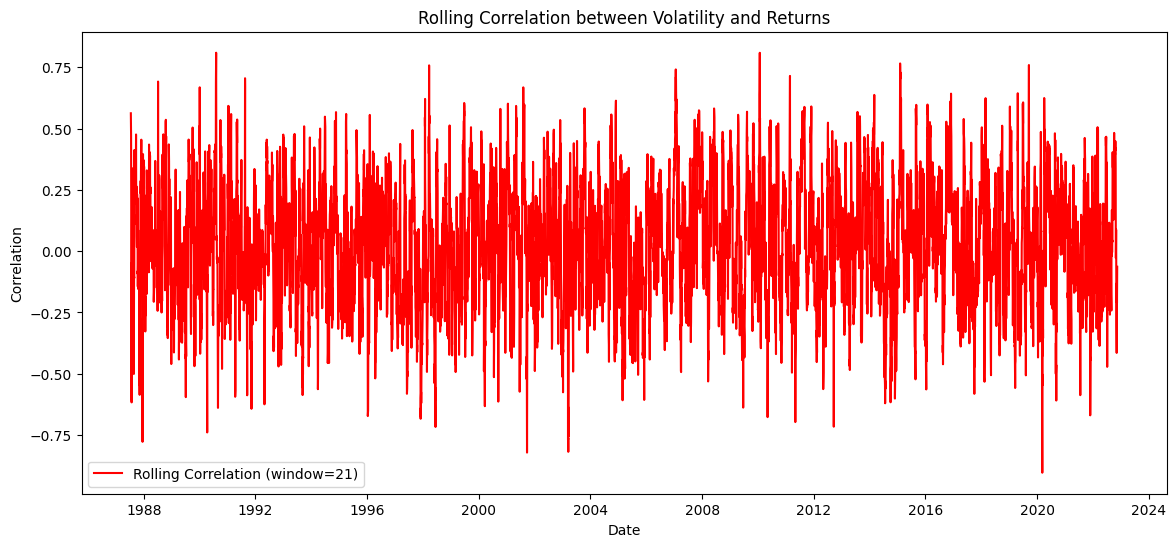

In [116]:
# Rolling Correlation
def rolling_correlation(df, window=21):
    """
    Calculate rolling correlation between volatility and returns.
    """
    df['Rolling_Corr'] = df['Volatility'].rolling(window).corr(df['Returns'])
    
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Rolling_Corr'], color='red', label=f'Rolling Correlation (window={window})')
    plt.title("Rolling Correlation between Volatility and Returns")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.legend()
    plt.show()

rolling_correlation(df)

In [117]:
def check_stationarity(df, column='Price'):
    """
    Perform the Augmented Dickey-Fuller test for stationarity.
    """
    result = adfuller(df[column])
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The data is stationary.")
    else:
        print("The data is non-stationary. Differencing may be needed.")


# Summary statistics
print("Descriptive statistics of Brent Oil Prices:")
display(df['Price'].describe())
check_stationarity(df)


Descriptive statistics of Brent Oil Prices:


count    8990.000000
mean       48.490186
std        32.867039
min         9.100000
25%        19.080000
50%        38.990000
75%        70.235000
max       143.950000
Name: Price, dtype: float64

ADF Statistic: -1.986246157536638
p-value: 0.29263604948116323
The data is non-stationary. Differencing may be needed.


In [118]:
# Define ARIMA Model
def arima_model(df, column='Price', p=1, d=1, q=1):
    """
    Fit ARIMA model and print summary.
    """
    model = ARIMA(df[column], order=(p, d, q))
    arima_result = model.fit()
    print(arima_result.summary())
    return arima_result

# Step 2: Model the data with ARIMA and GARCH
print("Fitting ARIMA model...")
arima_result = arima_model(df)

Fitting ARIMA model...
                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 8990
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14520.492
Date:                Sat, 02 Nov 2024   AIC                          29046.985
Time:                        14:25:44   BIC                          29068.296
Sample:                             0   HQIC                         29054.237
                               - 8990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3427      0.160     -2.147      0.032      -0.656      -0.030
ma.L1          0.3712      0.158      2.353      0.019       0.062       0.680
sigma2         1.4812      0.

In [119]:
# Define GARCH Model
def garch_model(df, column='Price'):
    """
    Fit GARCH model to capture volatility.
    """
    model = arch_model(df['Log_Returns'].dropna(), vol='Garch', p=1, q=1)
    garch_result = model.fit(disp="off")
    print(garch_result.summary())
    return garch_result

print("Fitting GARCH model for volatility analysis...")
garch_result = garch_model(df)


Fitting GARCH model for volatility analysis...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                22114.2
Distribution:                  Normal   AIC:                          -44220.4
Method:            Maximum Likelihood   BIC:                          -44192.0
                                        No. Observations:                 8990
Date:                Sat, Nov 02 2024   Df Residuals:                     8989
Time:                        14:25:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         

In [120]:
 #Residual Analysis for ARIMA and GARCH Models
def residual_analysis(model_results, title="Model Residuals"):
    """
    Plot residuals and ACF of residuals to check for white noise.
    """
    residuals = model_results.resid
    plt.figure(figsize=(12, 5))
    
    # Plot Residuals
    plt.subplot(1, 2, 1)
    plt.plot(residuals, color='blue')
    plt.title(f"{title} - Residuals")
    plt.xlabel("Date")
    plt.ylabel("Residuals")
    
    # Plot ACF of Residuals
    plt.subplot(1, 2, 2)
    plot_acf(residuals.dropna(), ax=plt.gca())
    plt.title("Residuals Autocorrelation")
    
    plt.tight_layout()
    plt.show()


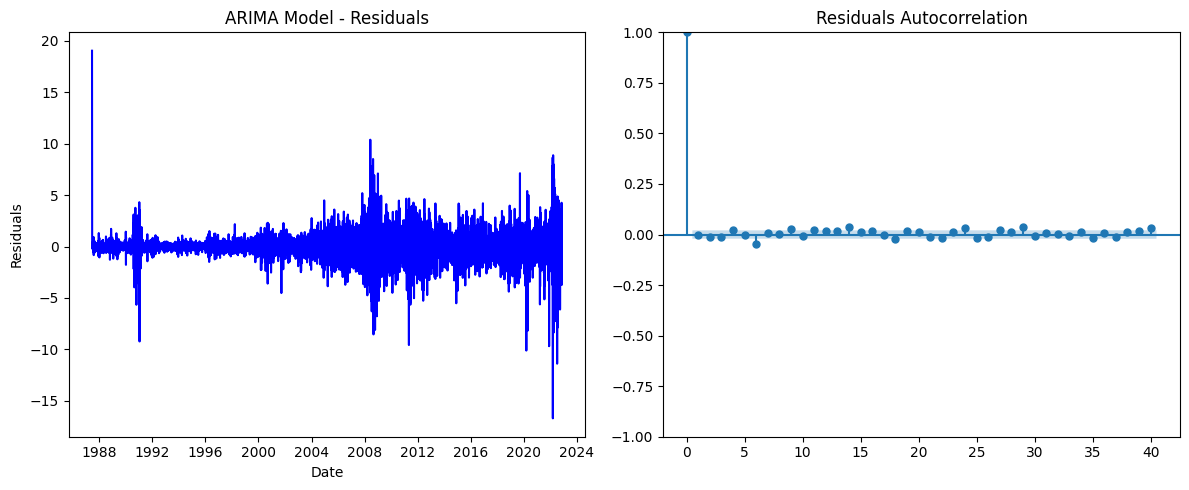

In [121]:
 # Residual Analysis for ARIMA
residual_analysis(arima_result, title="ARIMA Model")

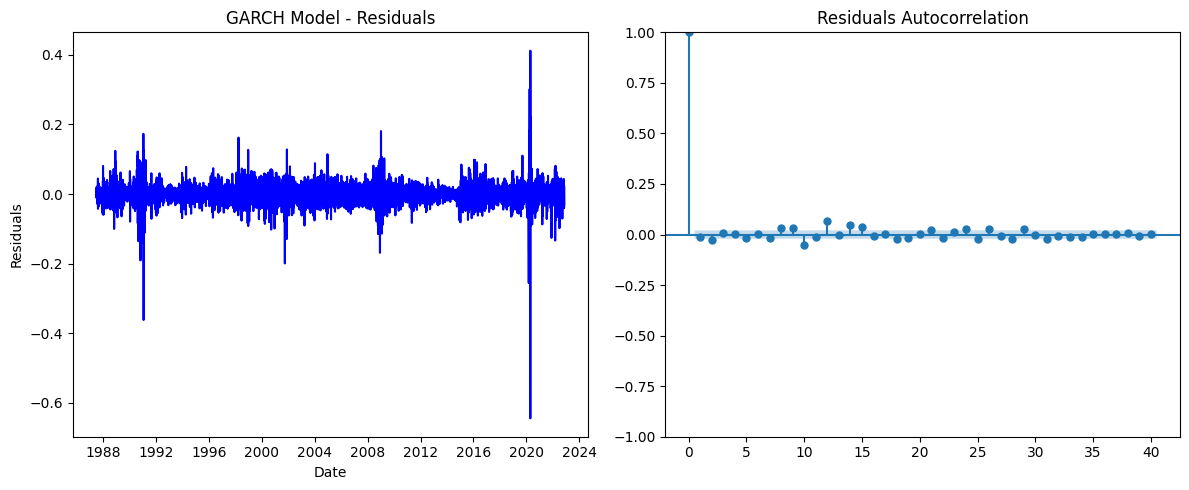

In [122]:
 # GARCH Model on Log Returns
residual_analysis(garch_result, title="GARCH Model")

In [123]:
# Event Data Preparation
def create_event_dataframe():
    """
    Create a DataFrame for significant events related to oil price changes.
    """
    events_data = [
        {"Date": "1987-01-01", "Event": "Market Liberalization", "Type": "Economic"},
        {"Date": "1990-08-02", "Event": "Gulf War", "Type": "Geopolitical"},
        {"Date": "1992-01-01", "Event": "OPEC Production Agreements", "Type": "OPEC"},
        {"Date": "1997-01-01", "Event": "Asian Financial Crisis", "Type": "Economic"},
        {"Date": "2000-03-01", "Event": "Dot-com Bubble Burst", "Type": "Economic"},
        {"Date": "2001-09-11", "Event": "September 11 Attacks", "Type": "Geopolitical"},
        {"Date": "2003-03-01", "Event": "Iraq War", "Type": "Geopolitical"},
        {"Date": "2004-01-01", "Event": "Rising Demand from China", "Type": "Demand"},
        {"Date": "2005-08-01", "Event": "Hurricane Katrina", "Type": "Natural Disaster"},
        {"Date": "2008-07-01", "Event": "Global Economic Growth", "Type": "Economic"},
        {"Date": "2008-09-01", "Event": "Global Financial Crisis", "Type": "Economic"},
        {"Date": "2009-01-01", "Event": "OPEC Production Cuts", "Type": "OPEC"},
        {"Date": "2010-01-01", "Event": "Arab Spring", "Type": "Geopolitical"},
        {"Date": "2011-01-01", "Event": "U.S. Shale Boom", "Type": "Production"},
        {"Date": "2011-01-01", "Event": "Sanctions on Iran", "Type": "Sanctions"},
        {"Date": "2014-11-01", "Event": "OPEC's Decision Not to Cut Production", "Type": "OPEC"},
        {"Date": "2016-01-01", "Event": "Iran Nuclear Deal", "Type": "Geopolitical"},
        {"Date": "2016-01-01", "Event": "OPEC Production Cuts", "Type": "OPEC"},
        {"Date": "2017-01-01", "Event": "Geopolitical Tensions", "Type": "Geopolitical"},
        {"Date": "2018-10-01", "Event": "U.S. Sanctions on Iran", "Type": "Sanctions"},
        {"Date": "2019-09-01", "Event": "Attacks on Saudi Oil Facilities", "Type": "Geopolitical"},
        {"Date": "2020-04-01", "Event": "COVID-19 Pandemic", "Type": "Pandemic"},
        {"Date": "2020-04-20", "Event": "Negative Oil Prices", "Type": "Economic"},
        {"Date": "2021-01-01", "Event": "Market Recovery Post-COVID", "Type": "Economic"},
        {"Date": "2021-01-01", "Event": "Rising Inflation and Supply Chain Issues", "Type": "Economic"},
        {"Date": "2022-02-01", "Event": "Russia-Ukraine War", "Type": "Geopolitical"},
        {"Date": "2022-12-01", "Event": "EU Sanctions on Russian Oil", "Type": "Sanctions"},
    ]
    
    events_df = pd.DataFrame(events_data)
    events_df['Date'] = pd.to_datetime(events_df['Date'])
    return events_df

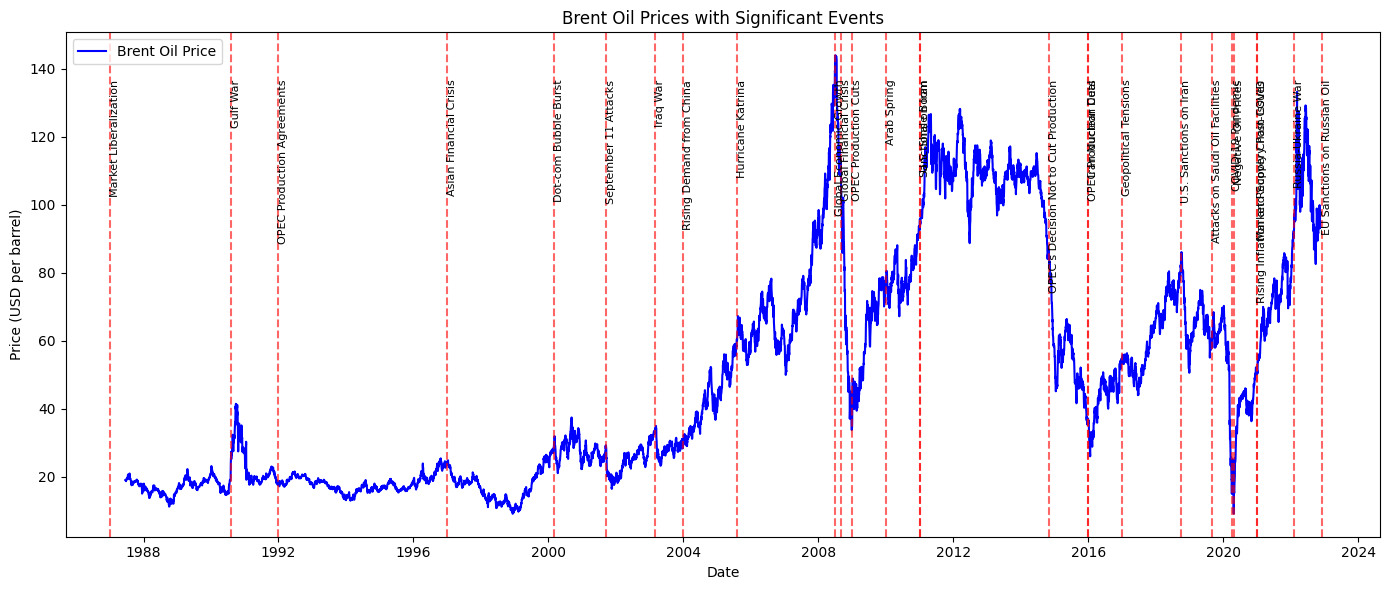

In [124]:
def plot_with_events(df, events_df):
    """
    Overlay events on the Brent oil price timeline.
    """
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['Price'], label='Brent Oil Price', color='blue')
    
    for _, row in events_df.iterrows():
        plt.axvline(row['Date'], color='red', linestyle='--', alpha=0.6)
        plt.text(row['Date'], df['Price'].max() * 0.95, row['Event'], rotation=90, verticalalignment='top', fontsize=8)
    
    plt.title("Brent Oil Prices with Significant Events")
    plt.xlabel("Date")
    plt.ylabel("Price (USD per barrel)")
    plt.legend()
    plt.tight_layout()
    plt.show()


 # Step 3: Overlay events on the time series
events_df = create_event_dataframe()
plot_with_events(df, events_df)

In [125]:

# Event Impact on Volatility and Returns
def event_impact_analysis(df, events_df):
    """
    Calculate the average volatility and returns around event dates to quantify impact.
    """
    impacts = []
    for _, event in events_df.iterrows():
        date = event['Date']
        # Define a window around the event date
        before = df.loc[date - pd.Timedelta(days=5):date - pd.Timedelta(days=1)]
        after = df.loc[date:date + pd.Timedelta(days=5)]
        
        # Calculate average volatility and returns before and after the event
        before_volatility = before['Volatility'].mean()
        after_volatility = after['Volatility'].mean()
        before_return = before['Returns'].mean()
        after_return = after['Returns'].mean()
        
        impacts.append({
            "Event": event['Event'],
            "Date": date,
            "Before_Volatility": before_volatility,
            "After_Volatility": after_volatility,
            "Before_Return": before_return,
            "After_Return": after_return,
        })
    
    impact_df = pd.DataFrame(impacts)
    print("Event Impact Analysis:")
    display(impact_df)
    return impact_df

 # Event Impact Analysis
impact_df = event_impact_analysis(df, events_df)

Event Impact Analysis:


,Event,Date,Before_Volatility,After_Volatility,Before_Return,After_Return
0,Market Liberalization,1987-01-01,NaN,NaN,NaN,NaN
1,Gulf War,1990-08-02,0.022837,0.036841,0.015649,0.083503
2,OPEC Production Agreements,1992-01-01,0.020062,0.021643,-0.000497,0.018553
3,Asian Financial Crisis,1997-01-01,0.018568,0.019098,0.003416,0.011981
4,Dot-com Bubble Burst,2000-03-01,0.012453,0.012918,0.009368,0.009178
5,September 11 Attacks,2001-09-11,0.015759,0.020680,0.016569,0.014997
6,Iraq War,2003-03-01,0.011144,0.012287,0.007513,0.003040
7,Rising Demand from China,2004-01-01,0.026963,0.031302,0.009673,0.011418
8,Hurricane Katrina,2005-08-01,0.021874,0.021303,0.006814,0.003219
9,Global Economic Growth,2008-07-01,0.026128,0.025373,0.017141,0.013214


In [126]:
df = pd.DataFrame(df)
df.to_csv("C:/Users/Administrator/Documents/kifiya/Week_10/data/preproccessed_brent_oil_prices.csv", index=False)